# Análise de Gênero no ICMC
**Importante** Este notebook foi desenvolvido como parte de um projeto de iniciação científica em 2024. Devido à natureza sensível dos dados contidos nos dataframes utilizados para as análises, optamos por omiti-los. Assim, o notebook não é executável e tem como finalidade exclusivamente a apresentação dos resultados.

---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import gzip
import io
import csv
import gzip
import io
from unicodedata import normalize


## Importação dos dados

In [ ]:
def identificar_encoding(data, encodings):
    """
    Identifica o encoding de um arquivo CSV.

    Args:
    - data (str): Caminho do arquivo CSV.
    - encodings (list): Lista de encodings para verificar.

    Returns:
    - str: Mensagem indicando o encoding identificado ou que nenhum encoding funcionou.
    """
    for encoding in encodings:
        try:
            with open(data, 'r', encoding=encoding) as f:
                f.read()
            return f"Encoding identificado: {encoding}"
        except Exception:
            pass
    return "Nenhum encoding compatível encontrado."

# Exemplo de uso
data = '/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2015-10.txt'
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'windows-1252']
print(identificar_encoding(data, encodings))


Encoding identificado: latin1


In [ ]:
# leiturapd.read_csv dos dados txt em csv
df2015 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2015-10.txt', decimal=',', sep=';', encoding='latin1')
df2016 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2016-10.txt', decimal=',', sep=';', encoding='latin1')
df2017 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2017-10.txt', decimal=',', sep=';', encoding='latin1')
df2018 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2018-10.txt', decimal=',', sep=';', encoding='latin1')
df2019 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2019-10.txt', decimal=',', sep=';', encoding='latin1')
df2020 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2020-10.txt', decimal=',', sep=';', encoding='latin1')
df2021 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2021-10.txt', decimal=',', sep=';', encoding='latin1')
df2022 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2022-10.txt', decimal=',', sep=';', encoding='latin1')
df2023 = pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2023-10.txt', decimal=',', sep=';', encoding='latin1')
df2024= pd.read_csv('/home/jpirolla/Documentos/Documents/USP/morbimortalidade/diversidadeicmc/dadostxt/USP-2024-03.txt', decimal=',', sep=';', encoding='latin1')


In [ ]:
# inserir coluna ano de cada df
df2015['ano']=2015
df2016['ano']=2016
df2017['ano']=2017
df2018['ano']=2018
df2019['ano']=2019
df2020['ano']=2020
df2021['ano']=2021
df2022['ano']=2022
df2023['ano']=2023
df2024['ano']=2024

# Seleção de colunas utilizadas e merge

In [ ]:
colunas_interesse = ['Nome', 'Unid/Orgão','Depto/Setor','Jornada', 'Categoria','Classe','Ref/MS', 'Função', 'ano']

In [ ]:
dataframes = [ df2016, df2017, df2018, df2019, df2020, df2021, df2022, df2024]

# Adicione df2017 ao início de dataframes
dataframes.insert(0, df2015)

merged_df = dataframes[0][colunas_interesse]

for df in dataframes[1:]:
    merged_df = pd.merge(merged_df, df[colunas_interesse], how='outer', on=colunas_interesse)


In [ ]:
merged_df.head(3)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano
0,Kenichi Roberto Ichiba,PUSP-SC,Seção de Alimentação,40 Horas,Celetista,Básico 1,A,Auxiliar de Serviços Gerais,2015
1,Maria Clara de Lima Costa Barretto,ESALQ,Serviço de Atividades Internacionais,40 Horas,Celetista,Técnico 1,A,Agente de Relacoes Internacionais,2015
2,Ricardo Ravanini Magalhães,HRAC,Seção de Pediatria,24 Horas,Celetista,Superior 1,A,Médico,2015


## Corrigindo departamentos

In [ ]:
# mapeamento só nos departamentos de interesse
mapeamento = {
    'Matemática' : 'SMA',
    'Matemática Aplicada e Estatística' : 'SME',
    'Sistemas de Computação' : 'SSC',
    'Ciências de Computação' : 'SCC',

}
merged_df['Depto/Setor'] = merged_df['Depto/Setor'].replace(mapeamento)

In [ ]:
# garantir que não mudei os demais
merged_df['Depto/Setor'].unique()

array(['Seção de Alimentação', 'Serviço de Atividades Internacionais',
       'Seção de Pediatria', ...,
       'Centro de Estudos e Tecnologias Convergentes para Oncologia de Precisão',
       'Colégio Técnico de Lorena Professor Nelson Pesciotta - COTEL',
       'Centro de Estudos de Carbono em Agricultura Tropical'],
      dtype=object)

Há pessoas cuja coluna Unid/Orgão ICMC e dpto também ICMC. Precisamos arrumar manualmente para fazer uma seleção por departamentos depois.

Para isso, fiz um loop que itera sobre cada linha do DataFrame `merged_df` e verifica se o nome presente na coluna 'Nome' está contido em uma das listas de departamentos: `SMA`, `SME`, `SSC`, `SCC`. Se o nome estiver presente em alguma das listas, o valor na coluna 'Depto/Setor' é atualizado de acordo com a lista correspondente.

Para construção da lista, consultei os nomes de Docentes da página do icmc https://www.icmc.usp.br/pessoas

In [ ]:
SCC =[ 'Agma Juci Machado Traina',
'Alneu de Andrade Lopes',
'Andre de Freitas Smaira',
'Bruna Carolina Rodrigues da Cunha',
'Caetano Traina Junior',
'Cristina Dutra de Aguiar',
'Diego Furtado Silva',
'Diego Raphael Amancio',
'Dilvan de Abreu Moreira',
'Elaine Parros Machado de Sousa',
'João do Espírito Santo Batista Neto',
'João Luis Garcia Rosa',
'José Fernando Rodrigues Junior',
'Kamila Rios da Hora Rodrigues',
'Marcelo Garcia Manzato',
'Maria Cristina Ferreira de Oliveira',
'Moacir Antonelli Ponti',
'Ricardo Cerri',
'Ricardo Marcondes Marcacini',
'Roseli Aparecida Francelin Romero',
'Rudinei Goularte',
'Solange Oliveira Rezende',
'Thiago Alexandre Salgueiro Pardo']

SMA = ['Alex Freitas de Campos',
'Alexandre Nolasco de Carvalho',
'Ali Tahzibi',
'Ana Claudia Nabarro',
'Ana Paula Peron',
'Behrooz Mirzaii',
'Carlos Alberto Maquera Apaza',
'Carlos Henrique Grossi Ferreira',
'Daniel Smania Brandão',
'Denner Dias Barros',
'Éder Rítis Aragão Costa',
'Ederson Moreira dos Santos',
'Edna Maura Zuffi',
'Eugenio Tommaso Massa',
'Evandro Raimundo da Silva',
'Farid Tari',
'Fernando Manfio',
'Fernando Nera Lenarduzzi',
'Gabriel Cueva Candido Soares de Araujo',
'Gabriel Zanetti Nunes Fernandes',
'Guilherme Lima Ferreira da Silva',
'Herivelto Martins Borges Filho',
'Igor Mencattini',
'José Eduardo Prado Pires de Campos'
]

SME = ['Adriano Kamimura Suzuki',
'Afonso Paiva Neto',
'André Carlos Ponce de Leon Ferreira de Carvalho',
'Antonio Castelo Filho',
'Cibele Maria Russo Novelli',
'Cynthia de Oliveira Lage Ferreira',
'Eduardo Fontoura Costa',
'Elias Salomão Helou Neto',
'Everaldo de Mello Bonotto',
'Fabrício Simeoni de Sousa',
'Francisco Aparecido Rodrigues',
'Francisco Louzada Neto',
'Franklina Maria Bragion de Toledo',
'Gustavo Carlos Buscaglia',
'Jorge Luis Bazán Guzmán',
'José Alberto Cuminato',
'Katiane Silva Conceição',
'Leandro Franco de Souza',
'Livia Souza Freire Grion',
'Luis Gustavo Nonato',
'Maria Luísa Bambozzi de Oliveira',
'Mariana Cúri',
'Marina Andretta',
'Marinho Gomes de Andrade Filho',
'Mário de Castro Andrade Filho',
'Maristela Oliveira dos Santos',
'Miguel Vinicius Santini Frasson',
'Oilson Alberto Gonzatto Junior',
'Paulo Afonso Faria da Veiga',
'Reiko Aoki',
'Ricardo Sandes Ehlers',
'Roberto Federico Ausas',
'Thomas Kauê Dal Maso Peron',
'Tiago Pereira da Silva',
'Vicente Garibay Cancho']


SSC = ['Adenilso da Silva Simão',
'Alexandre Cláudio Botazzo Delbem',
'Cláudio Fabiano Motta Toledo',
'Danilo Hernane Spatti',
'Denis Fernando Wolf',
'Eduardo do Valle Simões',
'Elisa Yumi Nakagawa',
'Ellen Francine Barbosa',
'Fernando Santos Osório',
'Francisco José Monaco',
'Jo Ueyama',
'Júlio Cezar Estrella',
'Kalinka Regina Lucas Jaquie Castelo Branco',
'Lina Maria Garces Rodriguez',
'Márcio Eduardo Delamaro',
'Paulo Sergio Lopes de Souza',
'Rodolfo Ipolito Meneguette',
'Rosana Teresinha Vaccare Braga',
'Sarita Mazzini Bruschi',
'Seiji Isotani',
'Simone do Rocio Senger de Souza',
'Vanderlei Bonato']

In [ ]:
# antes de corrigir (para comparação)
merged_df[merged_df['Nome']== 'Cibele Maria Russo Novelli']

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano
126669,Cibele Maria Russo Novelli,ICMC,Instituto de Ciências Matemáticas e de Computação,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2019
151544,Cibele Maria Russo Novelli,ICMC,Instituto de Ciências Matemáticas e de Computação,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2020
177245,Cibele Maria Russo Novelli,ICMC,Instituto de Ciências Matemáticas e de Computação,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2021
200978,Cibele Maria Russo Novelli,RUSP,Diretoria de Formação e Vida Profissional,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2022
224431,Cibele Maria Russo Novelli,RUSP,Diretoria de Formação e Vida Profissional,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2024


In [ ]:
# corrigir a unidade (se algum nome estiver na lista, mas não estiver com Unid/Orgao = ICMC)

for indice, linha in merged_df.iterrows():
    if linha['Nome'] in SMA or linha['Nome'] in SME or linha['Nome'] in SSC or linha['Nome'] in SCC:
        merged_df.at[indice, 'Unid/Orgão'] = 'ICMC'


In [ ]:
# corrigir o Depto/Setor para a lista correspondente
for indice, linha in merged_df.iterrows():
    if linha['Nome'] in SMA:
        merged_df.at[indice, 'Depto/Setor'] = 'SMA'
    elif linha['Nome'] in SME:
        merged_df.at[indice, 'Depto/Setor'] = 'SME'
    elif linha['Nome'] in SSC:
        merged_df.at[indice, 'Depto/Setor'] = 'SSC'
    elif linha['Nome'] in SCC:
        merged_df.at[indice, 'Depto/Setor'] = 'SCC'


In [ ]:
# antes de corrigir (para comparação)
merged_df[merged_df['Nome']== 'Cibele Maria Russo Novelli']

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano
126669,Cibele Maria Russo Novelli,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2019
151544,Cibele Maria Russo Novelli,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2020
177245,Cibele Maria Russo Novelli,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2021
200978,Cibele Maria Russo Novelli,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2022
224431,Cibele Maria Russo Novelli,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2024


## Filtros: Docentes ICMC e regime RDIDP

In [ ]:
# Filtrando as linhas de merged_df onde 'Depto' é ICMC e 'Jornada' RDIDP
df_icmc_regime = merged_df[(merged_df['Unid/Orgão'] == 'ICMC') & (merged_df['Jornada'] == 'RDIDP') & (merged_df['Depto/Setor'] != 'Inativo')]


In [ ]:
df_icmc_regime

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano
18603,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015
18660,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015
18800,Maria do Carmo Carbinatto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015
18891,Roberta Godoi Wik Atique,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015
18892,Sandra Maria Aluisio,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015
...,...,...,...,...,...,...,...,...,...
225645,Behrooz Mirzaii,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2024
225794,Oilson Alberto Gonzatto Junior,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024
225832,Livia Souza Freire Grion,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024
225890,Denner Dias Barros,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024


In [ ]:
df_icmc_regime

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano
18603,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015
18660,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015
18800,Maria do Carmo Carbinatto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015
18891,Roberta Godoi Wik Atique,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015
18892,Sandra Maria Aluisio,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015
...,...,...,...,...,...,...,...,...,...
225645,Behrooz Mirzaii,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2024
225794,Oilson Alberto Gonzatto Junior,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024
225832,Livia Souza Freire Grion,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024
225890,Denner Dias Barros,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-3.1,Professor Doutor,2024


## Script Gênero
- Atribuir M ou F dependento do primeiro nome

In [ ]:
# separando o primeiro nome em uma nova coluna
df_icmc_regime['primeiro nome'] = df_icmc_regime['Nome']
df_icmc_regime['primeiro nome'] = df_icmc_regime['Nome'].str.split().str.get(0)

/tmp/ipykernel_5248/1368012323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icmc_regime['primeiro nome'] = df_icmc_regime['Nome']
/tmp/ipykernel_5248/1368012323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icmc_regime['primeiro nome'] = df_icmc_regime['Nome'].str.split().str.get(0)


In [ ]:
def encode(name):
    ascii_name = normalize("NFKD", name).encode("ascii", errors="ignore").decode("ascii")
    return ascii_name.upper()

df_icmc_regime['nome maiusculo'] = df_icmc_regime['primeiro nome'].apply(encode)
df_icmc_regime.head(2)


/tmp/ipykernel_5248/698277956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icmc_regime['nome maiusculo'] = df_icmc_regime['primeiro nome'].apply(encode)


,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo
18603,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Eduardo,EDUARDO
18660,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Oziride,OZIRIDE


In [ ]:
df = df_icmc_regime

In [ ]:
# Passa tudo para maiúscula e sem acento

def encode(name):
    ascii_name = normalize("NFKD", name).encode("ascii", errors="ignore").decode("ascii")
    return ascii_name.upper()

for i in range(len(df)):
    df.iloc[i,1] = encode(df.iloc[i,1])

df.head(2)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo
18603,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Eduardo,EDUARDO
18660,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Oziride,OZIRIDE


In [ ]:
# Carregando um dicionário de nomes classificados
!wget https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz

def load_data():
    fobj = io.TextIOWrapper(gzip.open("nomes.csv.gz"), encoding="utf-8")
    csv_reader = csv.DictReader(fobj)
    data = {
        row["first_name"]: row["classification"]
        for row in csv_reader
    }
    fobj.close()
    return data

name_data = load_data()

print(f"Dicionário criado com {len(name_data)} nomes.")

--2024-04-26 23:09:36--  https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz
Resolvendo data.brasil.io (data.brasil.io)... 2606:4700:20::681a:8af, 2606:4700:20::ac43:472d, 2606:4700:20::681a:9af, ...
Conectando-se a data.brasil.io (data.brasil.io)|2606:4700:20::681a:8af|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 1895785 (1,8M) [application/gzip]
Salvando em: ‘nomes.csv.gz.9’

nomes.csv.gz.9      100%[===================>]   1,81M  3,98MB/s    em 0,5s    

2024-04-26 23:09:37 (3,98 MB/s) - ‘nomes.csv.gz.9’ salvo [1895785/1895785]

Dicionário criado com 100787 nomes.


In [ ]:
# Transformando em dataframe

df2 = pd.DataFrame.from_dict(name_data, orient = 'index')
df2['nome maiusculo'] = df2.index
df2['gênero'] = df2.loc[:,0]
df2 = df2[['nome maiusculo','gênero']]
df2

,nome maiusculo,gênero
AALINE,AALINE,F
AARAO,AARAO,M
AARON,AARON,M
ABA,ABA,F
ABADE,ABADE,M
...,...,...
MACLEIA,MACLEIA,F
GIULINE,GIULINE,F
DEMAILTON,DEMAILTON,M
ILIVIA,ILIVIA,F


In [ ]:
df = df.merge(df2, left_on='nome maiusculo', right_on='nome maiusculo', how='left')
df.head(10)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo,gênero
0,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Eduardo,EDUARDO,M
1,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Oziride,OZIRIDE,NaN
2,Maria do Carmo Carbinatto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Maria,MARIA,F
3,Roberta Godoi Wik Atique,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Roberta,ROBERTA,F
4,Sandra Maria Aluisio,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015,Sandra,SANDRA,F
5,Roseli Aparecida Francelin Romero,ICMC,SCC,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Roseli,ROSELI,F
6,Caetano Traina Junior,ICMC,SCC,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Caetano,CAETANO,M
7,Solange Oliveira Rezende,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Solange,SOLANGE,F
8,Daniel Levcovitz,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Daniel,DANIEL,M
9,Antonio Castelo Filho,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Antonio,ANTONIO,M


## Análise Gênero ICMC (total)

In [ ]:
# Contagem de ocorrências por ano e gênero
contagem_geral = df.groupby(['ano', 'gênero']).size().unstack()

contagem_geral

gênero,F,M
ano,,
2015,42,92
2016,43,91
2017,43,88
2018,41,87
2019,36,81
2020,36,81
2021,35,78
2022,34,78
2024,32,81


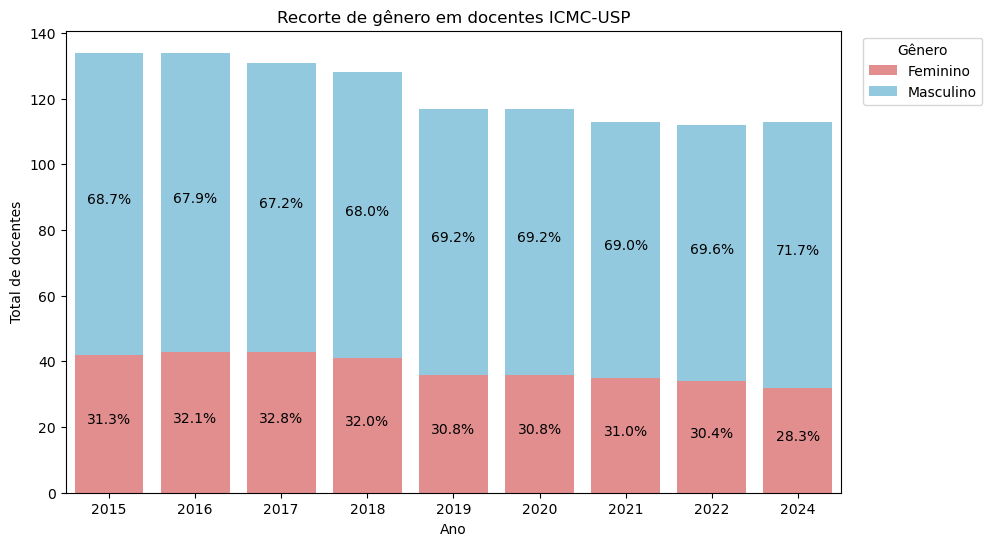

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_geral.reset_index(), x='ano', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_geral.reset_index(), x='ano', y='M', color='skyblue', bottom=contagem_geral['F'], label='Masculino')

total_por_ano = contagem_geral.sum(axis=1)

for p, total_ano in zip(plt.gca().patches, total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_geral):], total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Ano')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes ICMC-USP')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


### Análise por Classe e Ref

In [ ]:
# Contagem de ocorrências por ano e gênero
contagem_classe = df.groupby(['Classe', 'gênero']).size().unstack()

contagem_classe

gênero,F,M
Classe,,
Prof Doutor,298,600
Prof Titular,44,157


In [ ]:
contagem_ref = df.groupby(['Ref/MS', 'gênero']).size().unstack()

contagem_ref

gênero,F,M
Ref/MS,,
MS-3.1,67,158
MS-3.2,70,30
MS-5.1,114,234
MS-5.2,38,123
MS-5.3,9,55
MS-6,44,157


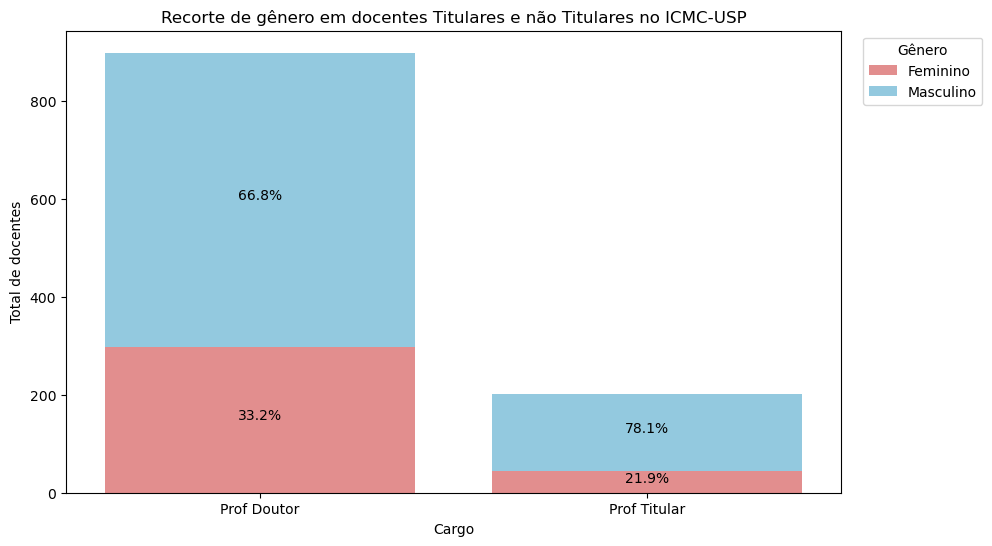

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_classe.reset_index(), x='Classe', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_classe.reset_index(), x='Classe', y='M', color='skyblue', bottom=contagem_classe['F'], label='Masculino')

total_por_classe = contagem_classe.sum(axis=1)

for p, total_ano in zip(plt.gca().patches, total_por_classe):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_classe):], total_por_classe):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Cargo')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes Titulares e não Titulares no ICMC-USP')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


In [ ]:
contagem_ref = df.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_ref

gênero,Ref/MS,F,M
0,MS-3.1,67,158
1,MS-3.2,70,30
2,MS-5.1,114,234
3,MS-5.2,38,123
4,MS-5.3,9,55
5,MS-6,44,157


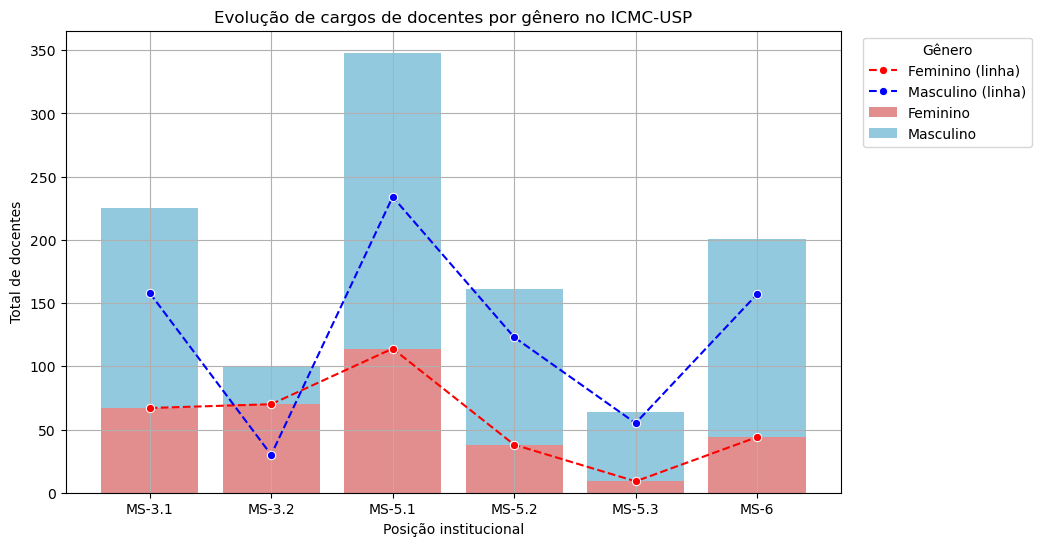

In [ ]:
contagem_ref['Total'] = contagem_ref['F'] + contagem_ref['M']

plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_ref, x='Ref/MS', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_ref, x='Ref/MS', y='M', color='skyblue', bottom=contagem_ref['F'], label='Masculino')

sns.lineplot(data=contagem_ref, x='Ref/MS', y='F', marker='o', color='red', label='Feminino (linha)', linestyle='--')
sns.lineplot(data=contagem_ref, x='Ref/MS', y='M', marker='o', color='blue', label='Masculino (linha)', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Evolução de cargos de docentes por gênero no ICMC-USP')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# Mapeamento das categorias para agrupar em associado, doutor e titular
categoria_mapping = {
    'MS-3.1': 'Doutor(a)',
    'MS-3.2': 'Doutor(a)',
    'MS-5.1': 'Associado(a)',
    'MS-5.2': 'Associado(a)',
    'MS-5.3': 'Associado(a)',
    'MS-6': 'Titular'
}

contagem_ref['Categoria'] = contagem_ref['Ref/MS'].map(categoria_mapping)
contagem_categorias = contagem_ref.groupby('Categoria', as_index=False).sum()

contagem_categorias

/tmp/ipykernel_5248/374152776.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contagem_categorias = contagem_ref.groupby('Categoria', as_index=False).sum()


gênero,Categoria,F,M,Total
0,Associado(a),161,412,573
1,Doutor(a),137,188,325
2,Titular,44,157,201


In [ ]:
categorias_desejadas = ['Doutor(a)', 'Associado(a)', 'Titular']

contagem_categorias['Categoria'] = pd.Categorical(contagem_categorias['Categoria'], categories=categorias_desejadas, ordered=True)
contagem_categorias = contagem_categorias.sort_values('Categoria')


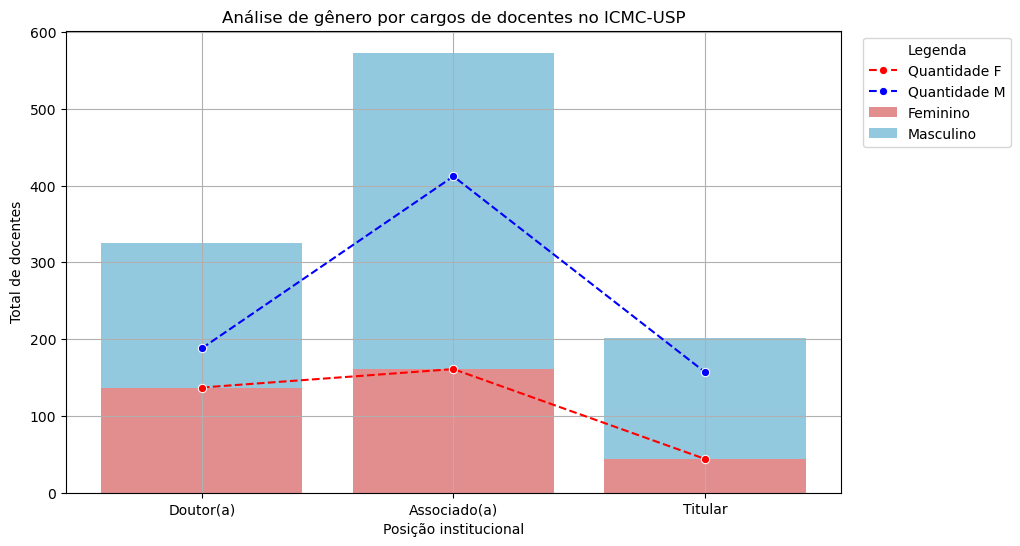

In [ ]:
# plot agrupando associado, doutor e titular
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_categorias, x='Categoria', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_categorias, x='Categoria', y='M', color='skyblue', bottom=contagem_categorias['F'], label='Masculino')

sns.lineplot(data=contagem_categorias, x='Categoria', y='F', marker='o', color='red', label='Quantidade F', linestyle='--')
sns.lineplot(data=contagem_categorias, x='Categoria', y='M', marker='o', color='blue', label='Quantidade M', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Análise de gênero por cargos de docentes no ICMC-USP')
plt.legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


## Análise SMA

### Análise por ano

In [ ]:
contagem_ref = df.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_ref


gênero,Ref/MS,F,M
0,MS-3.1,67,158
1,MS-3.2,70,30
2,MS-5.1,114,234
3,MS-5.2,38,123
4,MS-5.3,9,55
5,MS-6,44,157


In [ ]:
contagem_sma = df[df['Depto/Setor'] == 'SMA'].groupby(['ano', 'gênero']).size().unstack().reset_index()
contagem_sma

gênero,ano,F,M
0,2015,15,27
1,2016,15,27
2,2017,14,26
3,2018,12,30
4,2019,9,27
5,2020,12,26
6,2021,11,26
7,2022,10,25
8,2024,7,28


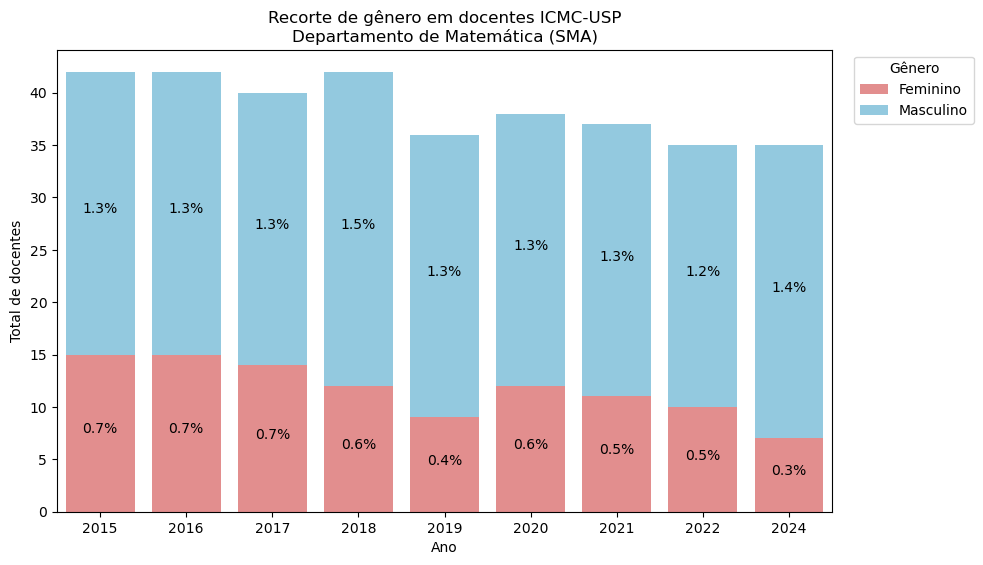

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_sma.reset_index(), x='ano', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sma.reset_index(), x='ano', y='M', color='skyblue', bottom=contagem_sma['F'], label='Masculino')

total_por_ano = contagem_sma.sum(axis=1)

for p, total_ano in zip(plt.gca().patches, total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_sma):], total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Ano')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes ICMC-USP\nDepartamento de Matemática (SMA)')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


### Análise por posição

In [ ]:
df_sma = df[df['Depto/Setor'] == 'SMA']
df_sma.head(5)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo,gênero
1,Oziride Manzoli Neto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Oziride,OZIRIDE,NaN
2,Maria do Carmo Carbinatto,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Maria,MARIA,F
3,Roberta Godoi Wik Atique,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Roberta,ROBERTA,F
8,Daniel Levcovitz,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Daniel,DANIEL,M
10,Miriam Garcia Manoel,ICMC,SMA,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Miriam,MIRIAM,F


In [ ]:
df_sma['Depto/Setor'].unique()

array(['SMA'], dtype=object)

In [ ]:
contagem_sma_ms = df_sma.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_sma_ms.columns = ['Ref/MS', 'F', 'M']
contagem_sma_ms

,Ref/MS,F,M
0,MS-3.1,14,51
1,MS-3.2,20,2
2,MS-5.1,58,80
3,MS-5.2,4,46
4,MS-5.3,2,14
5,MS-6,7,49


#### Posições Detalhadas

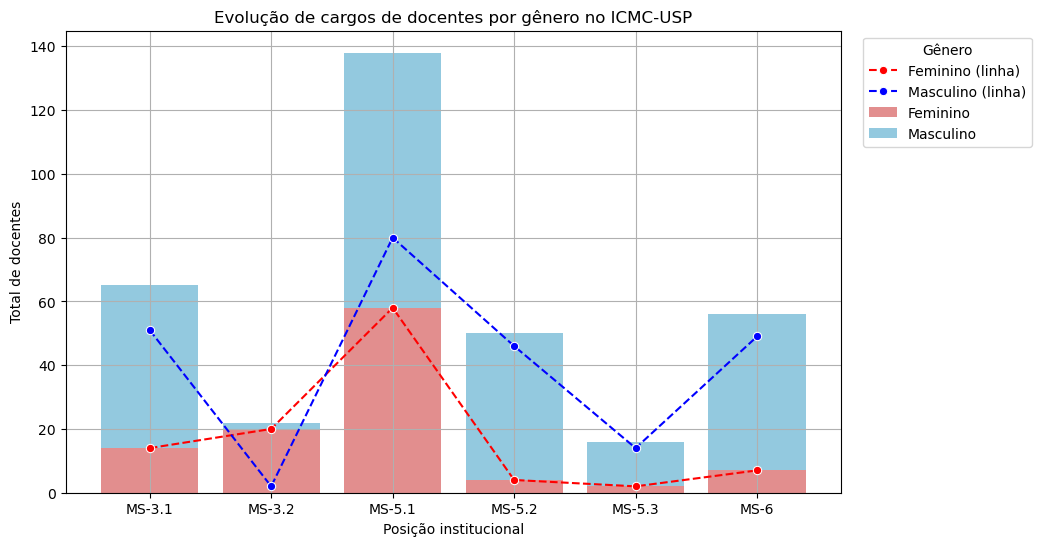

In [ ]:
contagem_sma_ms['Total'] = contagem_sma_ms ['F'] + contagem_sma_ms['M']

plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_sma_ms , x='Ref/MS', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sma_ms , x='Ref/MS', y='M', color='skyblue', bottom=contagem_sma_ms ['F'], label='Masculino')

sns.lineplot(data=contagem_sma_ms , x='Ref/MS', y='F', marker='o', color='red', label='Feminino (linha)', linestyle='--')
sns.lineplot(data=contagem_sma_ms , x='Ref/MS', y='M', marker='o', color='blue', label='Masculino (linha)', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Evolução de cargos de docentes por gênero no ICMC-USP')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


#### Agrupando em associado, doutor e titular

In [ ]:
# Mapeamento das categorias para agrupar em associado, doutor e titular
categoria_mapping = {
    'MS-3.1': 'Doutor(a)',
    'MS-3.2': 'Doutor(a)',
    'MS-5.1': 'Associado(a)',
    'MS-5.2': 'Associado(a)',
    'MS-5.3': 'Associado(a)',
    'MS-6': 'Titular'
}

contagem_sma_ms['Categoria'] = contagem_sma_ms['Ref/MS'].map(categoria_mapping)
contagem_sma_ms =contagem_sma_ms.groupby('Categoria', as_index=False).sum()

contagem_sma_ms['Categoria'] = pd.Categorical(contagem_sma_ms['Categoria'], categories=categorias_desejadas, ordered=True)

contagem_sma_ms = contagem_sma_ms.sort_values('Categoria')

/tmp/ipykernel_5248/2908122464.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contagem_sma_ms =contagem_sma_ms.groupby('Categoria', as_index=False).sum()


In [ ]:
contagem_sma_ms

,Categoria,F,M
1,Doutor(a),34,53
0,Associado(a),64,140
2,Titular,7,49


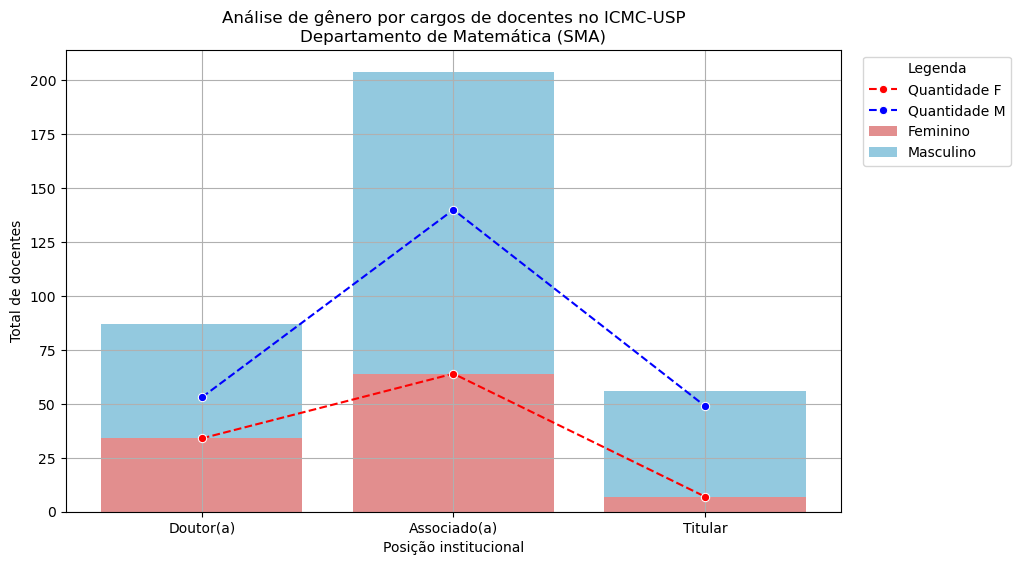

In [ ]:
# plot agrupando associado, doutor e titular
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_sma_ms, x='Categoria', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sma_ms, x='Categoria', y='M', color='skyblue', bottom=contagem_sma_ms['F'], label='Masculino')

sns.lineplot(data=contagem_sma_ms, x='Categoria', y='F', marker='o', color='red', label='Quantidade F', linestyle='--')
sns.lineplot(data=contagem_sma_ms, x='Categoria', y='M', marker='o', color='blue', label='Quantidade M', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Análise de gênero por cargos de docentes no ICMC-USP\nDepartamento de Matemática (SMA)')
plt.legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


## Análise SME

### Análise por ano

In [ ]:
df_sme = df[df['Depto/Setor'] == 'SME']
df_sme.head(5)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo,gênero
9,Antonio Castelo Filho,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Antonio,ANTONIO,M
13,Paulo Afonso Faria da Veiga,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Paulo,PAULO,M
23,André Carlos Ponce de Leon Ferreira de Carvalho,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,André,ANDRE,M
30,Franklina Maria Bragion de Toledo,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Franklina,FRANKLINA,F
33,Maristela Oliveira dos Santos,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015,Maristela,MARISTELA,F


In [ ]:
contagem_sme = df[df['Depto/Setor'] == 'SME'].groupby(['ano', 'gênero']).size().unstack()
contagem_sme

gênero,F,M
ano,,
2015,10,28
2016,10,27
2017,10,27
2018,9,28
2019,8,26
2020,8,25
2021,8,25
2022,10,25
2024,9,25


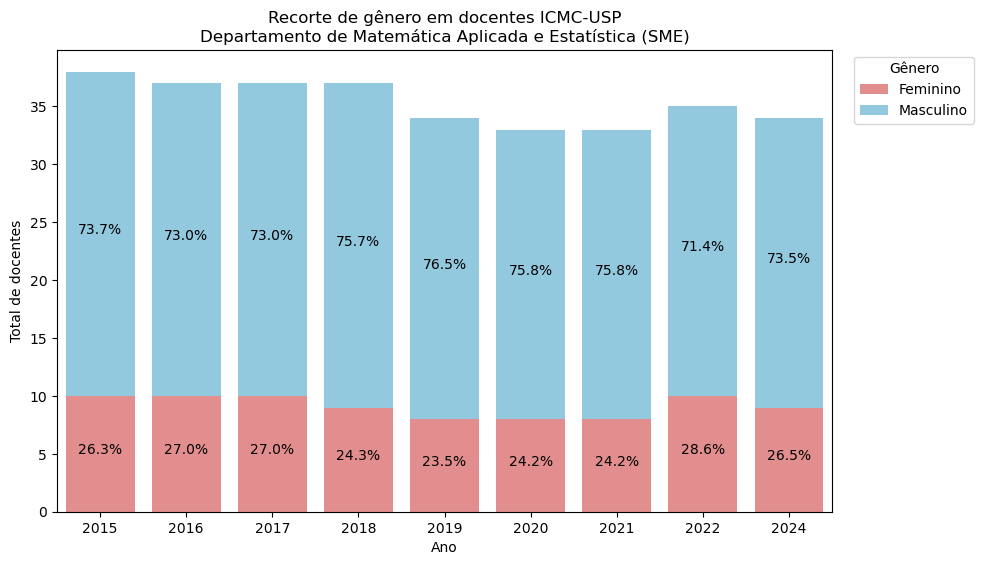

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_sme.reset_index(), x='ano', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sme.reset_index(), x='ano', y='M', color='skyblue', bottom=contagem_sme['F'], label='Masculino')

total_por_ano = contagem_sme.sum(axis=1)

for p, total_ano in zip(plt.gca().patches, total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_sme):], total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Ano')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes ICMC-USP\nDepartamento de Matemática Aplicada e Estatística (SME)')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


### Análise por posição

In [ ]:
df_sme = df[df['Depto/Setor'] == 'SME']
df_sme.head(5)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo,gênero
9,Antonio Castelo Filho,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Antonio,ANTONIO,M
13,Paulo Afonso Faria da Veiga,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Paulo,PAULO,M
23,André Carlos Ponce de Leon Ferreira de Carvalho,ICMC,SME,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,André,ANDRE,M
30,Franklina Maria Bragion de Toledo,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Franklina,FRANKLINA,F
33,Maristela Oliveira dos Santos,ICMC,SME,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015,Maristela,MARISTELA,F


In [ ]:
contagem_sme_ms = df_sme.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_sme_ms.columns = ['Ref/MS', 'F', 'M']
contagem_sme_ms

,Ref/MS,F,M
0,MS-3.1,37.0,40.0
1,MS-3.2,25.0,12.0
2,MS-5.1,14.0,59.0
3,MS-5.2,4.0,25.0
4,MS-5.3,2.0,30.0
5,MS-6,NaN,70.0


#### Análise detalhada

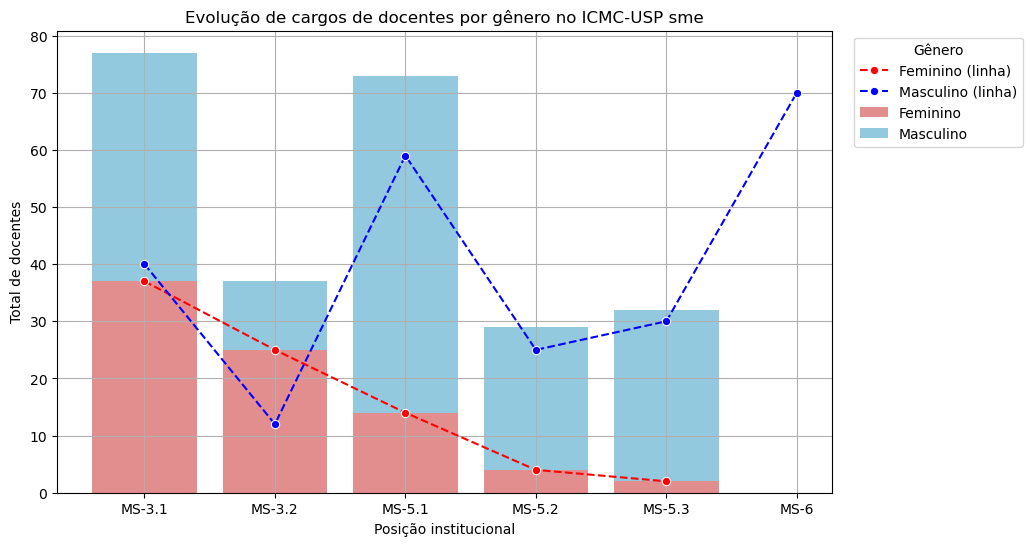

In [ ]:
contagem_sme_ms['Total'] = contagem_sme_ms ['F'] + contagem_sme_ms['M']

plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_sme_ms , x='Ref/MS', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sme_ms , x='Ref/MS', y='M', color='skyblue', bottom=contagem_sme_ms ['F'], label='Masculino')

sns.lineplot(data=contagem_sme_ms , x='Ref/MS', y='F', marker='o', color='red', label='Feminino (linha)', linestyle='--')
sns.lineplot(data=contagem_sme_ms , x='Ref/MS', y='M', marker='o', color='blue', label='Masculino (linha)', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Evolução de cargos de docentes por gênero no ICMC-USP sme')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


#### Agrupando em associado, doutor e titular

In [ ]:

contagem_sme_ms['Categoria'] = contagem_sme_ms['Ref/MS'].map(categoria_mapping)
contagem_sme_ms =contagem_sme_ms.groupby('Categoria', as_index=False).sum()

#arrumando ordem
contagem_sme_ms['Categoria'] = pd.Categorical(contagem_sme_ms['Categoria'], categories=categorias_desejadas, ordered=True)
contagem_sme_ms = contagem_sme_ms.sort_values('Categoria')
contagem_sme_ms

/tmp/ipykernel_5248/579219882.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contagem_sme_ms =contagem_sme_ms.groupby('Categoria', as_index=False).sum()


,Categoria,F,M,Total
1,Doutor(a),62.0,52.0,114.0
0,Associado(a),20.0,114.0,134.0
2,Titular,0.0,70.0,0.0


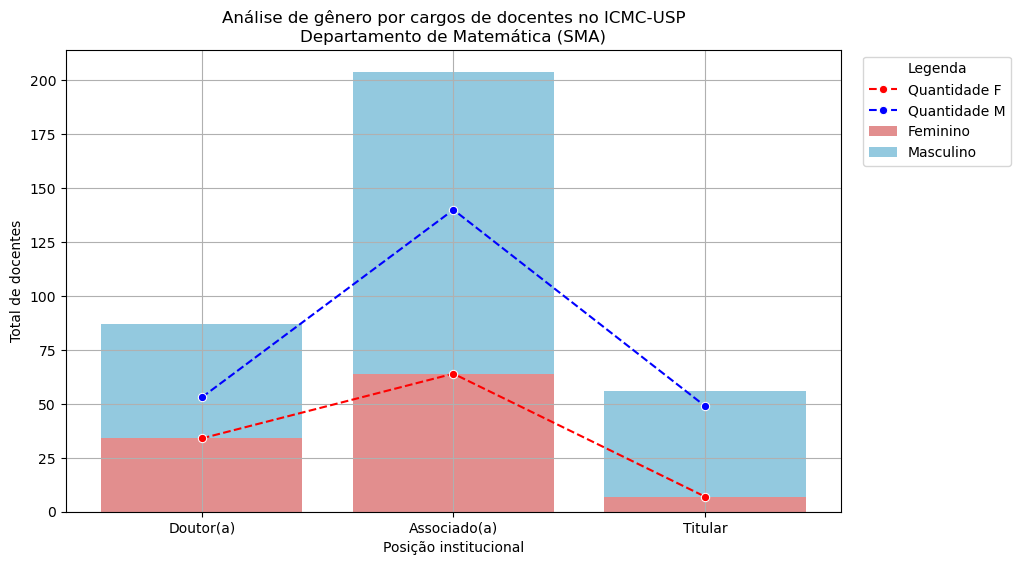

In [ ]:
# plot agrupando associado, doutor e titular
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_sma_ms, x='Categoria', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_sma_ms, x='Categoria', y='M', color='skyblue', bottom=contagem_sma_ms['F'], label='Masculino')

sns.lineplot(data=contagem_sma_ms, x='Categoria', y='F', marker='o', color='red', label='Quantidade F', linestyle='--')
sns.lineplot(data=contagem_sma_ms, x='Categoria', y='M', marker='o', color='blue', label='Quantidade M', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Análise de gênero por cargos de docentes no ICMC-USP\nDepartamento de Matemática (SMA)')
plt.legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


## Análise SSC

### Análise por ano

In [ ]:
contagem_ssc = df[df['Depto/Setor'] == 'SSC'].groupby(['ano', 'gênero']).size().unstack()
contagem_ssc

gênero,F,M
ano,,
2015,6,18
2016,6,18
2017,6,16
2018,6,14
2019,6,14
2020,6,14
2021,6,14
2022,6,14
2024,7,14


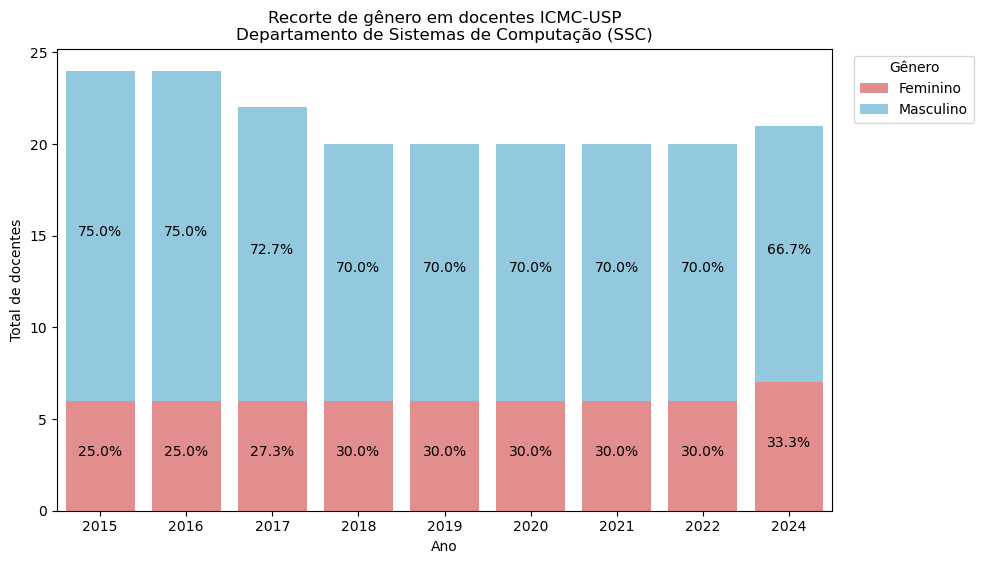

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_ssc.reset_index(), x='ano', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_ssc.reset_index(), x='ano', y='M', color='skyblue', bottom=contagem_ssc['F'], label='Masculino')

total_por_ano = contagem_ssc.sum(axis=1)

for p, total_ano in zip(plt.gca().patches, total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_sma):], total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Ano')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes ICMC-USP\nDepartamento de Sistemas de Computação (SSC)')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


### Análise por posição

In [ ]:
df_ssc = df[df['Depto/Setor'] == 'SSC']
df_sma.head(5)

In [ ]:
contagem_ssc_ms = df_sma.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_ssc_ms.columns = ['Ref/MS', 'F', 'M']
contagem_ssc_ms

,Ref/MS,F,M
0,MS-3.1,14,51
1,MS-3.2,20,2
2,MS-5.1,58,80
3,MS-5.2,4,46
4,MS-5.3,2,14
5,MS-6,7,49


#### Análise detalhada

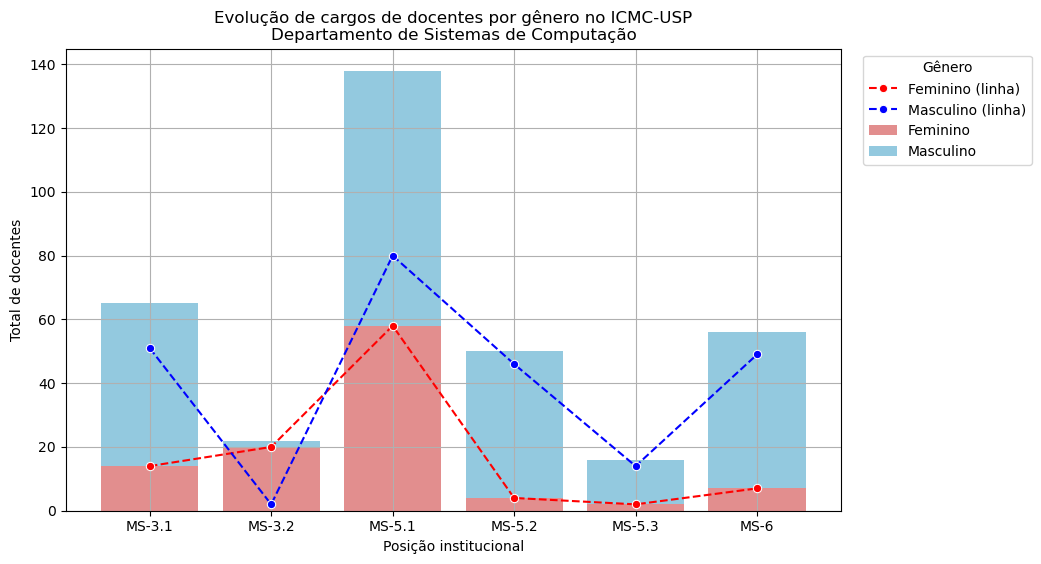

In [ ]:

contagem_ssc_ms['Total'] = contagem_sma_ms ['F'] + contagem_sma_ms['M']

# Tamanho da figura
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_ssc_ms , x='Ref/MS', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_ssc_ms , x='Ref/MS', y='M', color='skyblue', bottom=contagem_ssc_ms ['F'], label='Masculino')

sns.lineplot(data=contagem_ssc_ms , x='Ref/MS', y='F', marker='o', color='red', label='Feminino (linha)', linestyle='--')
sns.lineplot(data=contagem_ssc_ms , x='Ref/MS', y='M', marker='o', color='blue', label='Masculino (linha)', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Evolução de cargos de docentes por gênero no ICMC-USP\nDepartamento de Sistemas de Computação')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()


#### Agrupando em associado, doutor e titular

In [ ]:

contagem_ssc_ms['Categoria'] = contagem_ssc_ms['Ref/MS'].map(categoria_mapping)
contagem_ssc_ms =contagem_ssc_ms.groupby('Categoria', as_index=False).sum()
#arrumando ordem colunas
contagem_ssc_ms['Categoria'] = pd.Categorical(contagem_ssc_ms['Categoria'], categories=categorias_desejadas, ordered=True)
contagem_ssc_ms = contagem_ssc_ms.sort_values('Categoria')
contagem_ssc_ms

/tmp/ipykernel_5248/3090139798.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contagem_ssc_ms =contagem_ssc_ms.groupby('Categoria', as_index=False).sum()


,Categoria,F,M,Total
1,Doutor(a),34,53,291.0
0,Associado(a),64,140,56.0
2,Titular,7,49,0.0


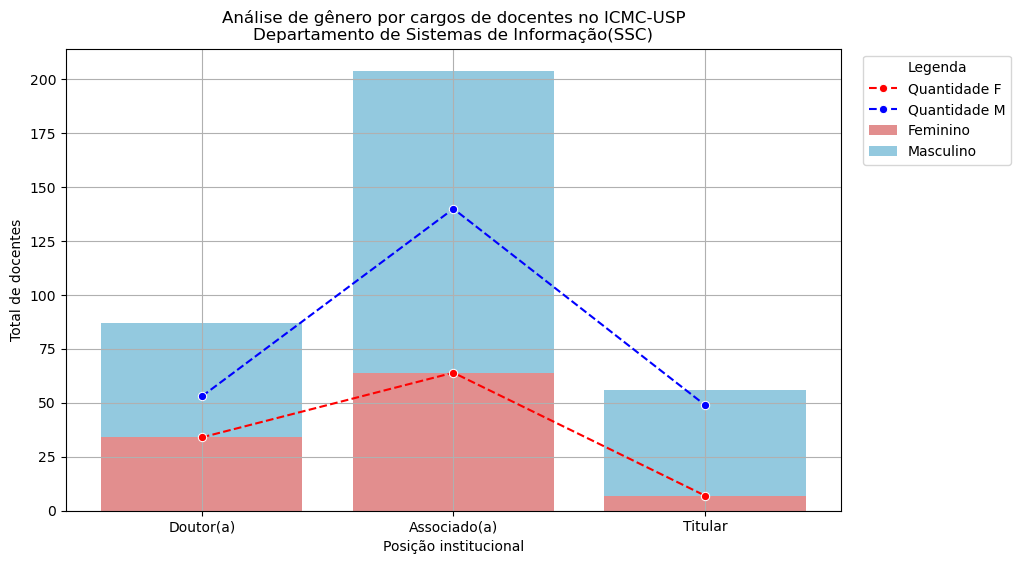

In [ ]:
# plot agrupando associado, doutor e titular
plt.figure(figsize=(10, 6))

sns.barplot( data=contagem_ssc_ms, x='Categoria', y='F', color='lightcoral', label='Feminino')
sns.barplot( data=contagem_ssc_ms, x='Categoria', y='M', color='skyblue', bottom=contagem_ssc_ms['F'], label='Masculino')
sns.lineplot(data=contagem_ssc_ms, x='Categoria', y='F', marker='o', color='red', label='Quantidade F', linestyle='--')
sns.lineplot(data=contagem_ssc_ms, x='Categoria', y='M', marker='o', color='blue', label='Quantidade M', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Análise de gênero por cargos de docentes no ICMC-USP\nDepartamento de Sistemas de Informação(SSC)')
plt.legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)  # Adiciona grade ao gráfico
plt.show()


## Análise SCC

### Análise por ano

In [ ]:
contagem_scc = df[df['Depto/Setor'] == 'SCC'].groupby(['ano', 'gênero']).size().unstack()
contagem_scc

gênero,F,M
ano,,
2015,8,16
2016,9,16
2017,10,16
2018,9,14
2019,9,14
2020,9,15
2021,9,12
2022,7,12
2024,8,12


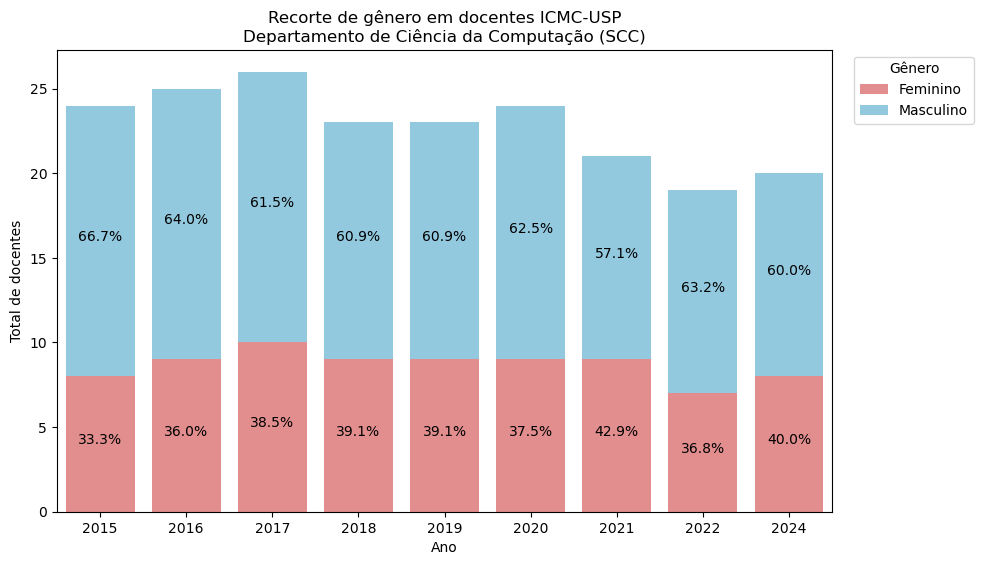

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contagem_scc.reset_index(), x='ano', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_scc.reset_index(), x='ano', y='M', color='skyblue', bottom=contagem_scc['F'], label='Masculino')

total_por_ano = contagem_scc.sum(axis=1)

# porcentagens em cada setor
for p, total_ano in zip(plt.gca().patches, total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

for p, total_ano in zip(plt.gca().patches[len(contagem_scc):], total_por_ano):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.annotate(f'{height/total_ano*100:.1f}%', (x + width/2, y + height*0.5), ha='center', fontsize=10)

plt.xlabel('Ano')
plt.ylabel('Total de docentes')
plt.title('Recorte de gênero em docentes ICMC-USP\nDepartamento de Ciência da Computação (SCC)')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


### Análise por posição

In [ ]:
df_scc = df[df['Depto/Setor'] == 'SCC']
df_scc.head(5)

,Nome,Unid/Orgão,Depto/Setor,Jornada,Categoria,Classe,Ref/MS,Função,ano,primeiro nome,nome maiusculo,gênero
0,Eduardo Raul Hruschka,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.2,Professor Associado,2015,Eduardo,EDUARDO,M
4,Sandra Maria Aluisio,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-3.2,Professor Doutor,2015,Sandra,SANDRA,F
5,Roseli Aparecida Francelin Romero,ICMC,SCC,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Roseli,ROSELI,F
6,Caetano Traina Junior,ICMC,SCC,RDIDP,Docente,Prof Titular,MS-6,Professor Titular,2015,Caetano,CAETANO,M
7,Solange Oliveira Rezende,ICMC,SCC,RDIDP,Docente,Prof Doutor,MS-5.1,Professor Associado,2015,Solange,SOLANGE,F


In [ ]:
contagem_scc_ms = df_scc.groupby(['Ref/MS', 'gênero']).size().unstack().reset_index()
contagem_scc_ms.columns = ['Ref/MS', 'F', 'M']
contagem_scc_ms

,Ref/MS,F,M
0,MS-3.1,11,34
1,MS-3.2,7,2
2,MS-5.1,11,54
3,MS-5.2,15,26
4,MS-5.3,1,2
5,MS-6,33,9


#### Análise posição detalhada

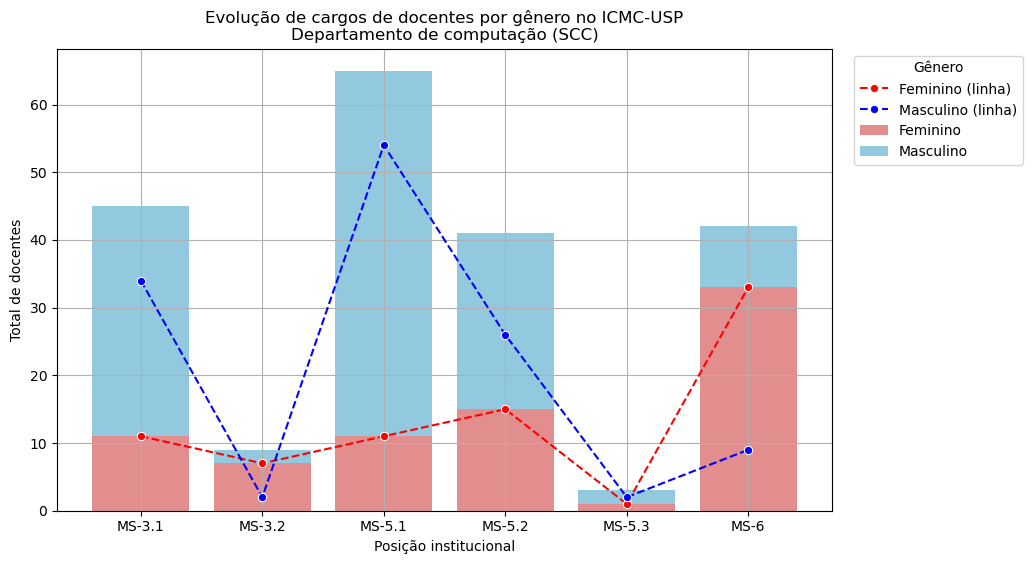

In [ ]:

contagem_scc_ms['Total'] = contagem_scc_ms ['F'] + contagem_scc_ms['M']

# Tamanho da figura
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_scc_ms , x='Ref/MS', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_scc_ms , x='Ref/MS', y='M', color='skyblue', bottom=contagem_scc_ms ['F'], label='Masculino')

sns.lineplot(data=contagem_scc_ms , x='Ref/MS', y='F', marker='o', color='red', label='Feminino (linha)', linestyle='--')
sns.lineplot(data=contagem_scc_ms , x='Ref/MS', y='M', marker='o', color='blue', label='Masculino (linha)', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Evolução de cargos de docentes por gênero no ICMC-USP\nDepartamento de computação (SCC)')
plt.legend(title='Gênero', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)  # Adiciona grade ao gráfico
plt.show()


#### Agrupando em associado, doutor e titular

In [ ]:

contagem_scc_ms['Categoria'] = contagem_scc_ms['Ref/MS'].map(categoria_mapping)
contagem_scc_ms =contagem_ssc_ms.groupby('Categoria', as_index=False).sum()
contagem_scc_ms['Categoria'] = pd.Categorical(contagem_scc_ms['Categoria'], categories=categorias_desejadas, ordered=True)
contagem_scc_ms = contagem_scc_ms.sort_values('Categoria')
contagem_scc_ms

,Categoria,F,M,Total
0,Doutor(a),34,53,291.0
1,Associado(a),64,140,56.0
2,Titular,7,49,0.0


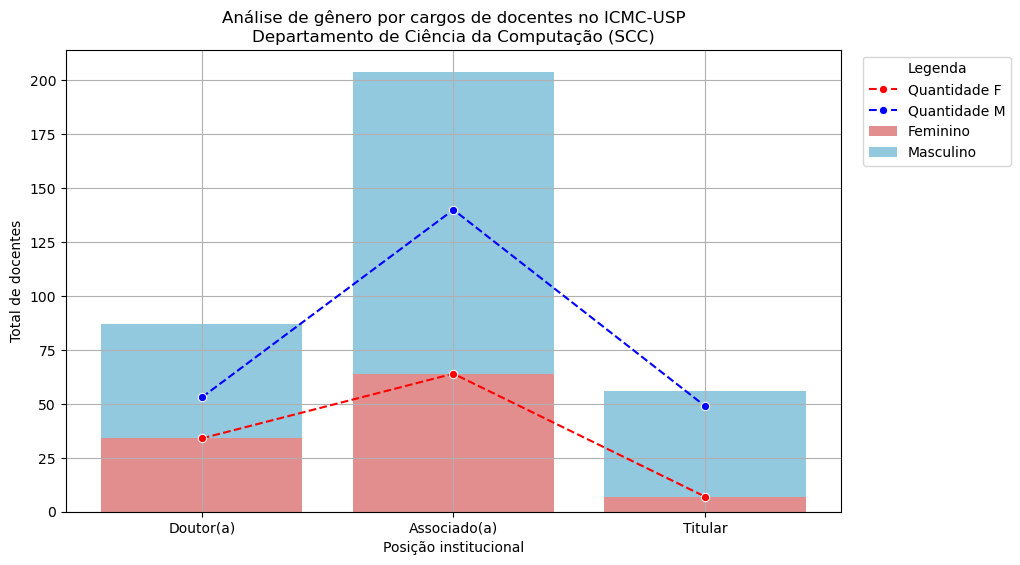

In [ ]:
# plot agrupando associado, doutor e titular
plt.figure(figsize=(10, 6))

sns.barplot(data=contagem_scc_ms, x='Categoria', y='F', color='lightcoral', label='Feminino')
sns.barplot(data=contagem_scc_ms, x='Categoria', y='M', color='skyblue', bottom=contagem_scc_ms['F'], label='Masculino')

sns.lineplot(data=contagem_scc_ms, x='Categoria', y='F', marker='o', color='red', label='Quantidade F', linestyle='--')
sns.lineplot(data=contagem_scc_ms, x='Categoria', y='M', marker='o', color='blue', label='Quantidade M', linestyle='--')

plt.xlabel('Posição institucional')
plt.ylabel('Total de docentes')
plt.title('Análise de gênero por cargos de docentes no ICMC-USP\nDepartamento de Ciência da Computação (SCC)')
plt.legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.show()
